# KV Cache - 10 баллов

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from dataclasses import dataclass

Представим, что у нас есть очень простая мини-LLM:
1. Она эмбеддит токены
2. Считает аттеншн (обычный, не multihead) токенов друг с другом с causal mask (не смотрит в будущее!)
3. После этого выходы attention подаются в линейный слой для получения распределеняи по словарю

На примере такой модели давайте попробуем имплементировать KV-Cache.

Ниже за вас написан метод forward - этот метод это обычный forward нейросети, который считает attention всех токенов со всеми токенами.

Вам же нужно имплементировать метод forward_kv_cache, который принимает:
* x - тензор размерности \[batch, seq_len = 1\]
* prev_output - выход модели с предыдущего шага типа Output

Метод forward_kv_cache должен выполнять следующие действия:
1. Эмбеддинг токена x
2. Проекция x в QKV
3. Расширение k_cache и v_cache из prev_ouptut k/v проекциями x
4. Подсчет аттеншена между q_x и k_cache и v_cache
5. Конкатенация аттеншена в prev_output.attention_weights
6. Возврат logits

In [21]:
@dataclass
class Output:
    logits: torch.Tensor = None
    k_cache: torch.Tensor = None
    v_cache: torch.Tensor = None
    attn_weights: torch.Tensor = None
    


class SimpleAttentionLLM(nn.Module):
    
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.lin = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        q = self.W_Q(x)
        k = self.W_K(x)
        v = self.W_V(x)
        
        attn_scores = torch.matmul(q, k.permute(0, 2, 1))
        mask = torch.tril(torch.ones_like(attn_scores))
        attn_scores = attn_scores.masked_fill(~mask.bool(), -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=2)
        weights_V = torch.matmul(attn_weights, v)
        logits = self.lin(weights_V)
        return Output(
            logits=logits,
            k_cache=k,
            v_cache=v,
            attn_weights=attn_weights # batch, seq_len, seq_len
        )
    
    
    def forward_kv_cache(self, x, prev_output):
        # эмбеддинг токена x
        x = self.embedding(x)
        
        # 1. Проецируем x в q, k, v
        q = self.W_Q(x)
        k = self.W_K(x)
        v = self.W_V(x)
        
        # print(f"{q.shape=}")
        # print(f"{k.shape=}")

        # берем старый кэш
        k_cache = prev_output.k_cache
        v_cache = prev_output.v_cache

        # расширяем его состояниями k, v последнего токена
        # с помощью torch.cat
        k_cache_new = torch.cat(tensors=(k_cache, k), dim=1)
        v_cache_new = torch.cat(tensors=(v_cache, v), dim=1)
        
        # считаем attention_score, то есть матричное умножение между q и k_cache_new
        
        attn_scores = q @ k_cache_new.permute(0, 2, 1)
    
        
        # считаем softmax
        attn_weights = torch.softmax(attn_scores, dim=-1)
        # домножаем softmax на V
        
        # print(f"{attn_scores.shape=}")
        # print(f"{v_cache_new.shape=}")
        weights_V = attn_weights @ v_cache_new
        logits = self.lin(weights_V)
        
        batch = x.size(0)
        seq_len = k_cache.size(1)
        
        attn_weights_old = prev_output.attn_weights
        zeros_right = torch.zeros(batch, seq_len, 1)
        # добавляем нули в аттеншене так, чтобы у старых токенов был нулевой аттеншн на новый токен
        attn_weights_all = torch.cat((attn_weights_old, zeros_right), dim=2)
        # Добавляем аттеншн текущего нового токена по старым
        attn_weights_all = torch.cat((attn_weights_all, attn_weights), dim=1)
        
        return Output(
            logits=logits,
            k_cache=k_cache_new,
            v_cache=v_cache_new,
            attn_weights=attn_weights_all
        )
        
torch.manual_seed(1)

batch_size = 1
seq_len = 3
d_model = 128
vocab_size = 7

layer = SimpleAttentionLLM(d_model, vocab_size)
for param in layer.parameters():
    nn.init.normal_(param)

x = torch.randint(0, 7, (batch_size, seq_len))
x_copy = x.clone()

print("Before generation", x)

with torch.no_grad():
    for i in range(10):
        outputs = layer(x)
        logits = outputs.logits
        # берем последний токен, т.к. по нему предсказываем!
        next_token = logits[:, -1].argmax(dim=1, keepdim=True)
        x = torch.cat((x, next_token), dim=1) # добавляем новый токен по размерности seq_len

no_cache_output = outputs
print("After generation no cache", x)


x = x_copy.clone()
final_tokens = x.clone()

with torch.no_grad():
    # prefill
    outputs = layer(x)
    logits = outputs.logits
    # берем последний токен, т.к. по нему предсказываем!
    next_token = logits[:, -1].argmax(dim=1, keepdim=True)
    # обратите внимание, что раньше было 10 шагов!
    final_tokens = torch.cat((final_tokens, next_token), dim=1)
    for i in range(9):
        outputs = layer.forward_kv_cache(next_token, outputs)
        next_token = outputs.logits[:, -1].argmax(dim=1, keepdim=True)
        final_tokens = torch.cat((final_tokens, next_token), dim=1)
    
print("After generation kv cache", final_tokens)

cache_outputs = outputs
        

Before generation tensor([[1, 3, 0]])
After generation no cache tensor([[1, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]])
After generation kv cache tensor([[1, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]])


Выведем матрицы attention

Text(0.5, 1.0, 'Attention kv cache')

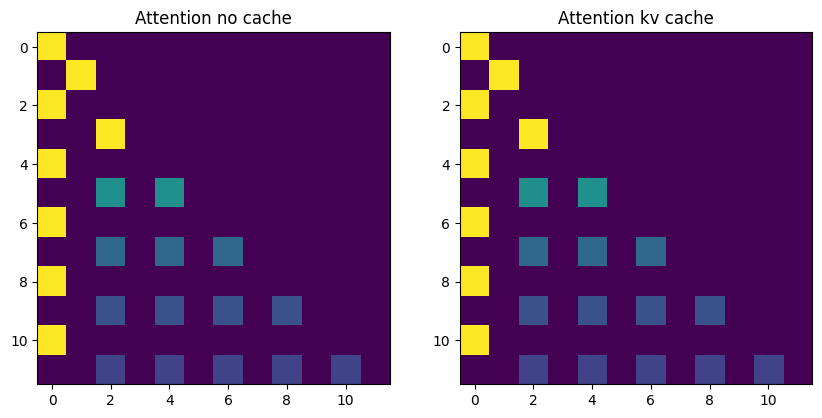

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(no_cache_output.attn_weights[0])
axes[0].set_title("Attention no cache")
axes[1].imshow(cache_outputs.attn_weights[0])
axes[1].set_title("Attention kv cache")

In [25]:
!pip install vllm triton

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 6.2 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [239 lines of output]
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.0/48.7 MB ? eta -:--:--
                                                    0.1/48.7 MB 221.3 kB/s eta 0:03:40
                                                    0.1/48.7 MB 221.3 kB/s eta 0:03:40
                                                    0.1/48.7 MB 2

По возможности данное задание необходимо выполнять на сервере, чтобы было удобно запускать параллельно фреймворк и нагрузочное тестирование. Для удобства работы в jupyter сделан следующий трюк

In [ ]:
import time
import multiprocessing
import subprocess

def start_vllm_server():
    # This function will run the `vllm` server command
    cmd = ["vllm", "serve", "unsloth/gemma-2b-it", "--dtype", "half"]
    subprocess.run(cmd)


server_process = multiprocessing.Process(target=start_vllm_server)
server_process.start()
time.sleep(60)
print("we are probably ready")

import requests

r = requests.post("http://localhost:8000/v1/completions", json={
                  "model": "unsloth/gemma-2b-it",
                  "prompt": "Hello there",
                  "max_tokens": 20,
                  "temperature": 0.8
              })
print(r.json())
print(r.json()["choices"][0]["text"])


# Нагрузочное тестирование - 25 баллов

20 баллов - узнать, сколько запросов в секунду выдержит VLLM сервинг модели при ограничении latency в 5 секунд.
Можно использовать самописную функцию через multiprocessing/threading, можно использовать любой готовый инструмент.

В качестве пейлоадов предлагается брать тексты длины 100-128 и генерировать к ним не более 10 токенов. Сами пейлоады можно взять из любого датасета, например https://huggingface.co/datasets/Intel/orca_dpo_pairs.

Об аргументах vllm serve можно почитать в документации https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html


5 баллов - если сможете посчитать на этом пейлоаде ttft - time to first token, то есть сколько занимает prefill стадия генерации.

In [ ]:
from vllm import LLM, SamplingParams

def generate_responses_batch(
        tokenizer,
        model,
        messages_list,
        max_new_tokens=128,
        temperature=0.8,
        device='cuda'
    ) -> list[str]:

    # Составляем промпт в LLM, используя apply_chat_template, чтобы проставились все нужные спец тоцены
    input_texts = [
        tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False
        )
        for messages in messages_list
    ]
    ### ваш код здесь
    sampling_params = SamplingParams(
        temperature=temperature,
        max_tokens=max_new_tokens
      )
    llm = LLM(model=model_name,
              dtype=torch.half,
              enforce_eager=True,
              gpu_memory_utilization=.8,
              # max_model_len = 4096*4,
              # max_num_seqs=4,
              # kv_cache_dtype="fp8"
              )
    outputs = llm.generate(input_texts, sampling_params)


    out_texts = []
    for output in outputs:
      prompt = output.prompt
      out_texts.append(output.outputs[0].text)

    return out_texts

assert all(
    "London" in candidate
    for candidate in generate_responses_batch(
        tokenizer=tokenizer,
        model=model,
        messages_list=[[{"role": "user", "content": "What is the capital of Great Britain?"}]] * 4,
  )
)

# Часть 2
Далее предоставлено 2 варианта выполнения задания. Баллы будут начисляться только на один из них
## Вариант 1. Квантизация - 15 баллов
Квантизируйте модель в VLLM любым доступным способом, напишите, как сократились затраты памяти и как изменилась скорость инференса. Обязательно укажите, на какой видеокарте проводились замеры!
Не забудьте про то, что квантизировать можно и kv cache.

Внимательно проверьте и убедитесь, что ваш ускоритель поддержан в https://docs.vllm.ai/en/latest/quantization/supported_hardware.html

## Вариант 2. Батчевалка - 15 баллов
Предлагается написать сервер на питоне, который поддерживал бы батчевание запросов.

Сервер принимает POST запрос с телом вида

```json
{"text": "Hello there"}
```


Необходимо написать сервер, который:
1. Имел бы возможность работать с несколькими клиентами за раз (не блокировался бы на обработку одного запроса). Для этого можно использовать async, gevent, треды и т.д.
2. Использовал бы батчовую обработку следующим образом:
если пришло несколько запросов (для примера 2)

```json
запрос 1
{"text": "Hello there "}
запрос 2
{"text": "handsome"}
```

то каждый клиент получал бы в ответ конкатенацию этих запросов (в произвольном порядке), т.е. оба клиента получили бы ответ
```json
{"text": "Hello there handsome"}
или
{"text": "handsomeHello there "}
```

Сервер должен иметь 2 конфигурируемых параметра:
1. Максимальный размер батча, который он может обработать
2. Максимальное время ожидания, которое ждет сэмпл перед обработкой. Т.е. если у нас батч размера 5, а у нас всего один сэмпл, и прошло максимальное время ожидания - этот сэмпл попадает в батч один и обрабатывается один.

Для хранения данных в очереди можно использовать queue.Queue или любой другой удобный способ.